In [ ]:
"""
Visualization

It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in
a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets.
The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual
concepts.  Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. We won’t
survey all of them, but we’ll cover three of the most accessible and useful ones:

1. Visualizing intermediate convnet outputs (intermediate activations) — Useful for understanding how successive convnet layers transform
   their input, and for getting a first idea of the meaning of individual convnet filters.

2. Visualizing convnets filters—Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.

3. Visualizing heatmaps of class activation in an image—Useful for understanding which parts of an image were identified as belonging to
   a given class, thus allowing you to localize objects in images.
"""

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       147584    
__________

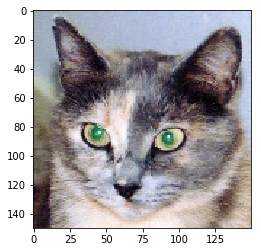

In [4]:
"""
Visualizing intermediate activations (1)

Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers
in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function).
This gives a view into how an input is decomposed into the different filters learned by the network. You want to visualize feature maps
with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to
visualize these feature maps is by independently plotting the contents of every channel as a 2D image. 
"""
from keras.models import load_model
from keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np

# model reminder
model = load_model('./model/cats_and_dogs_small_2.h5')
print(model.summary())

# get a picture of a cat
img_path = './data/small_cat_dog/test/cats/cat.1700.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
print("before expand: ", img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print("after expand: ", img_tensor.shape)

# display the picture
plt.imshow(img_tensor[0])
plt.show()

(1, 148, 148, 32)


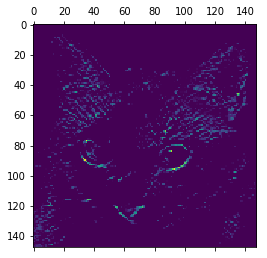

In [5]:
"""
Visualizing intermediate activations (2)

1. In order to extract the feature maps you want to look at, you’ll create a Keras model that takes batches of images as input, and
   outputs the activations of all convolution and pooling layers. To do this, you’ll use the Keras class Model. A model is instantiated
   using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors). The resulting class
   is a Keras model, just like the Sequential models, mapping the specified inputs to the specified outputs. What sets the Model class
   apart is that it allows for models with multiple outputs, unlike Sequential.

2. When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you’ve
   encountered a multi-output model: until now, the models you’ve seen have had exactly one input and one output. In the general case,
   a model can have any number of inputs and outputs. This one has one input and eight outputs: one output per layer activation.
"""
from keras import models
from keras import layers

# extract the outputs of the top 8 layers
layer_outputs = [layer.output for layer in model.layers[:8]]

# create a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

# the actication of first convolution layer for cat image input
first_layer_activation = activations[0]
print(first_layer_activation.shape)

# 4th channel
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis') 

/data/home/zhangmu/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


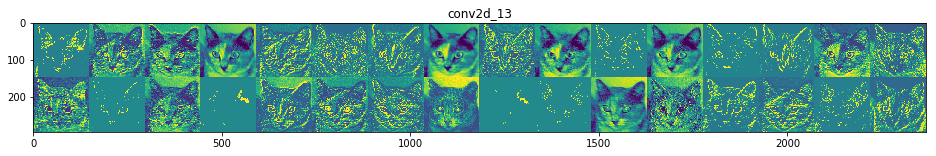

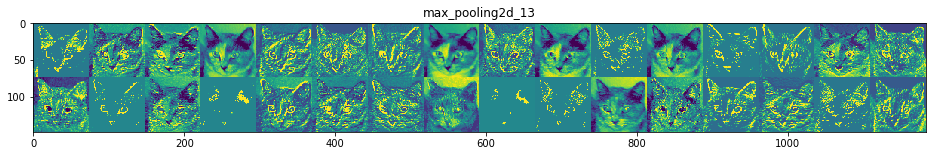

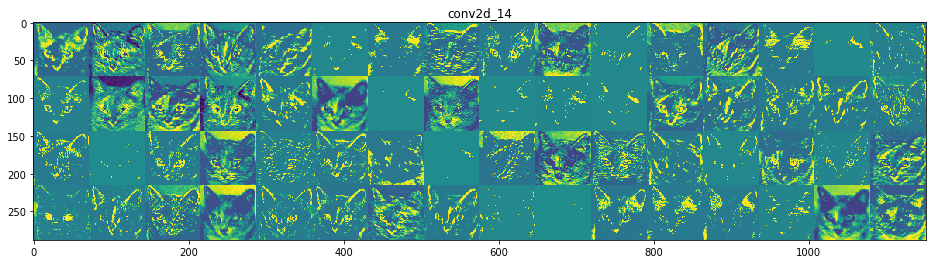

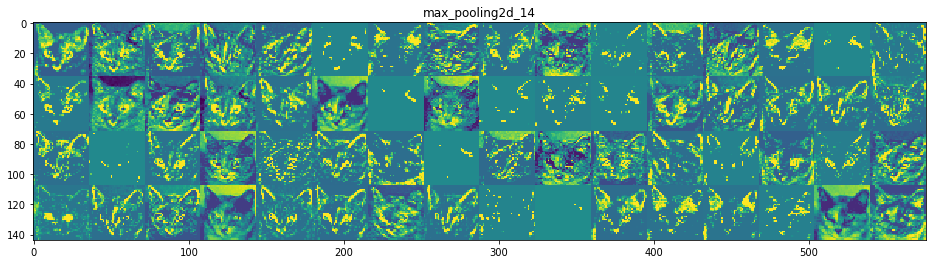

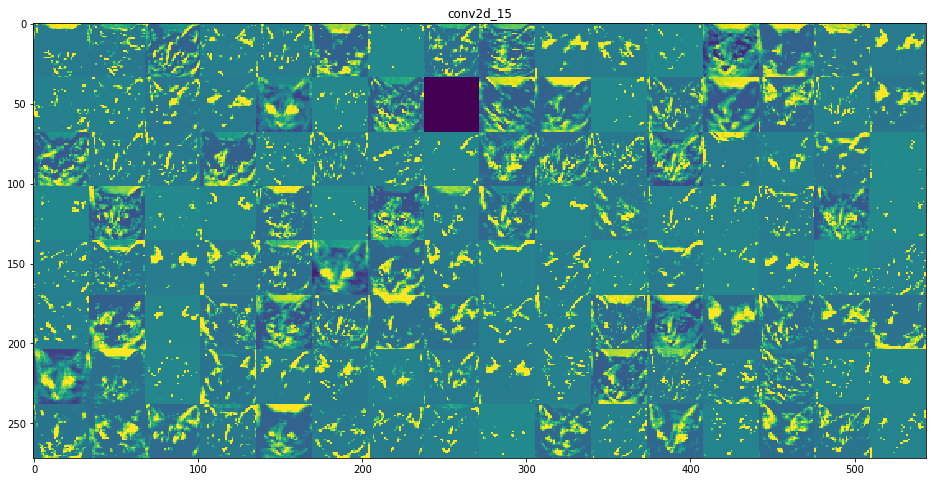

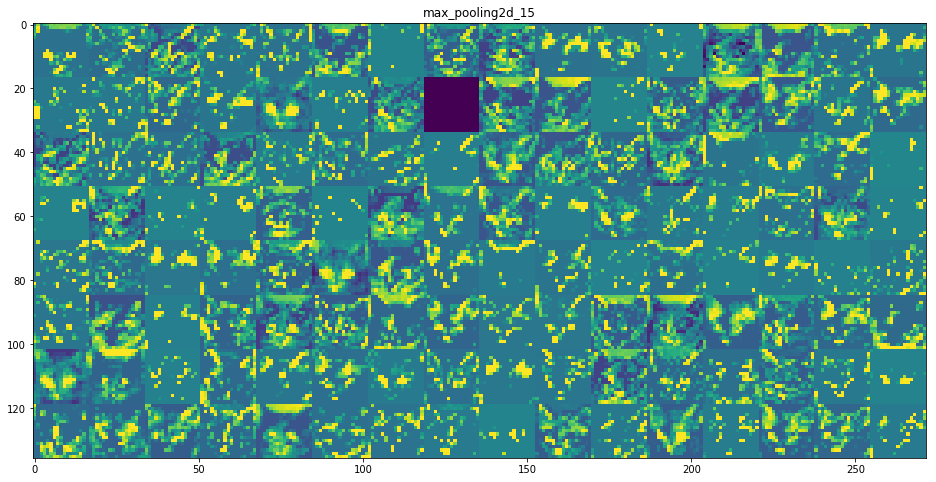

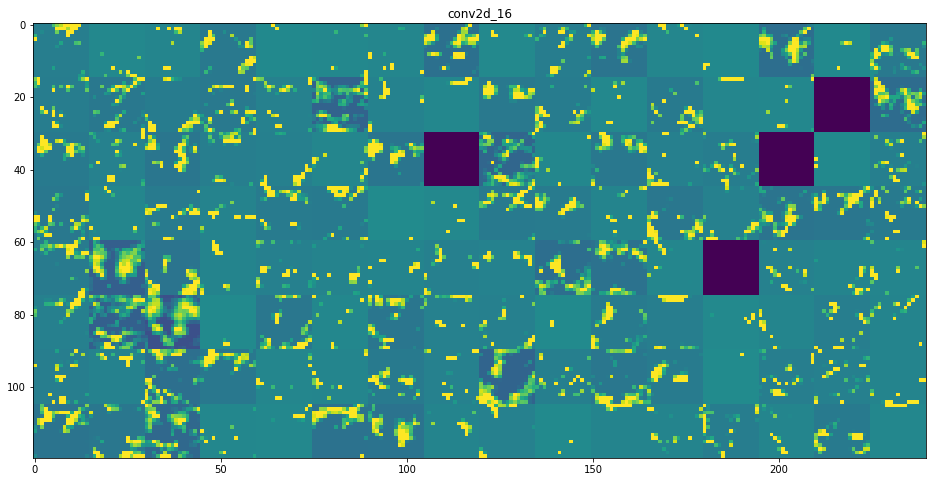

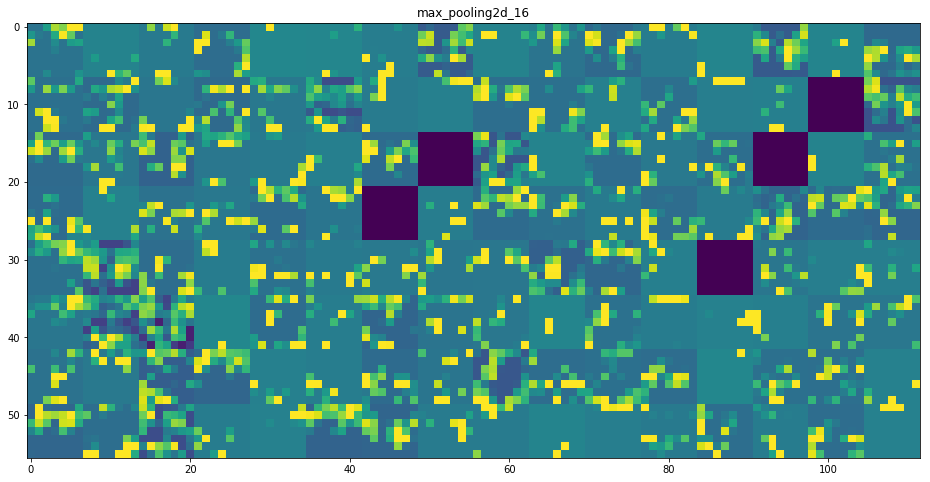

In [6]:
"""
Visualizing intermediate activations (3)

1. Few things to note:
   -- The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information
      present in the initial picture.
   -- As go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts
      such as “cat ear” and “cat eye.” Higher presentations carry increasingly less information about the visual contents of the image,
      and increasingly more information related to the class of the image.
   -- The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input
      image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in
      the input image.

2. An important universal characteristic of the representations learned by deep neural networks: the features extracted by a layer become
   increasingly abstract with the depth of the layer. The activations of higher layers carry less and less information about the specific
   input being seen, and more and more information about the target (in this case, the class of the image: cat or dog). A deep neural
   network effectively acts as an information distillation pipeline, with raw data going in (in this case, RGB pictures) and being
   repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and
   useful information is magnified and refined (for example, the class of the image).
"""
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0])) 
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

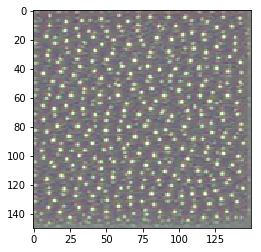

In [8]:
"""
Visualizing Convnet Filters (1)

1. Another easy way to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to.
   This can be done with gradient ascent in input space: applying gradient descent to the value of the input image of a convnet so as
   to maximize the response of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen
   filter is maximally responsive to.

2. The process is simple: you’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then
   you’ll use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value.
"""
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

# utility function to convert a tensor into a valid image
def deprocess_image(x):
    # normalizes the tensor: centers on 0, ensures that std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    
    # clips to [0, 1]
    x = np.clip(x, 0, 1)
    
    # converts to an RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# function to generate filter visualizations
def generate_pattern(layer_name, filter_index, size=150):
    # build a loss function that maximizes the value of a given filter in a given convolution layer,
    # and then you’ll use stochastic gradient descent to adjust the values of the input image so as
    # to maximize this activation value.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # computes the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # gradient-normalization, and adding 1e-5 is to avoid accidentally dividing by 0.
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # define a Keras backend function to do this: iterate is a function that takes a Numpy tensor
    # (as a list of tensors of size 1) and returns a list of two Numpy tensors: the loss value and the gradient value.
    iterate = K.function([model.input], [loss, grads]) # Returns the loss and grads given the input picture
    
    # starts from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)


# pattern that the zeroth channel in layer block3_conv1 responds to maximally
plt.imshow(generate_pattern('block3_conv1', 0))

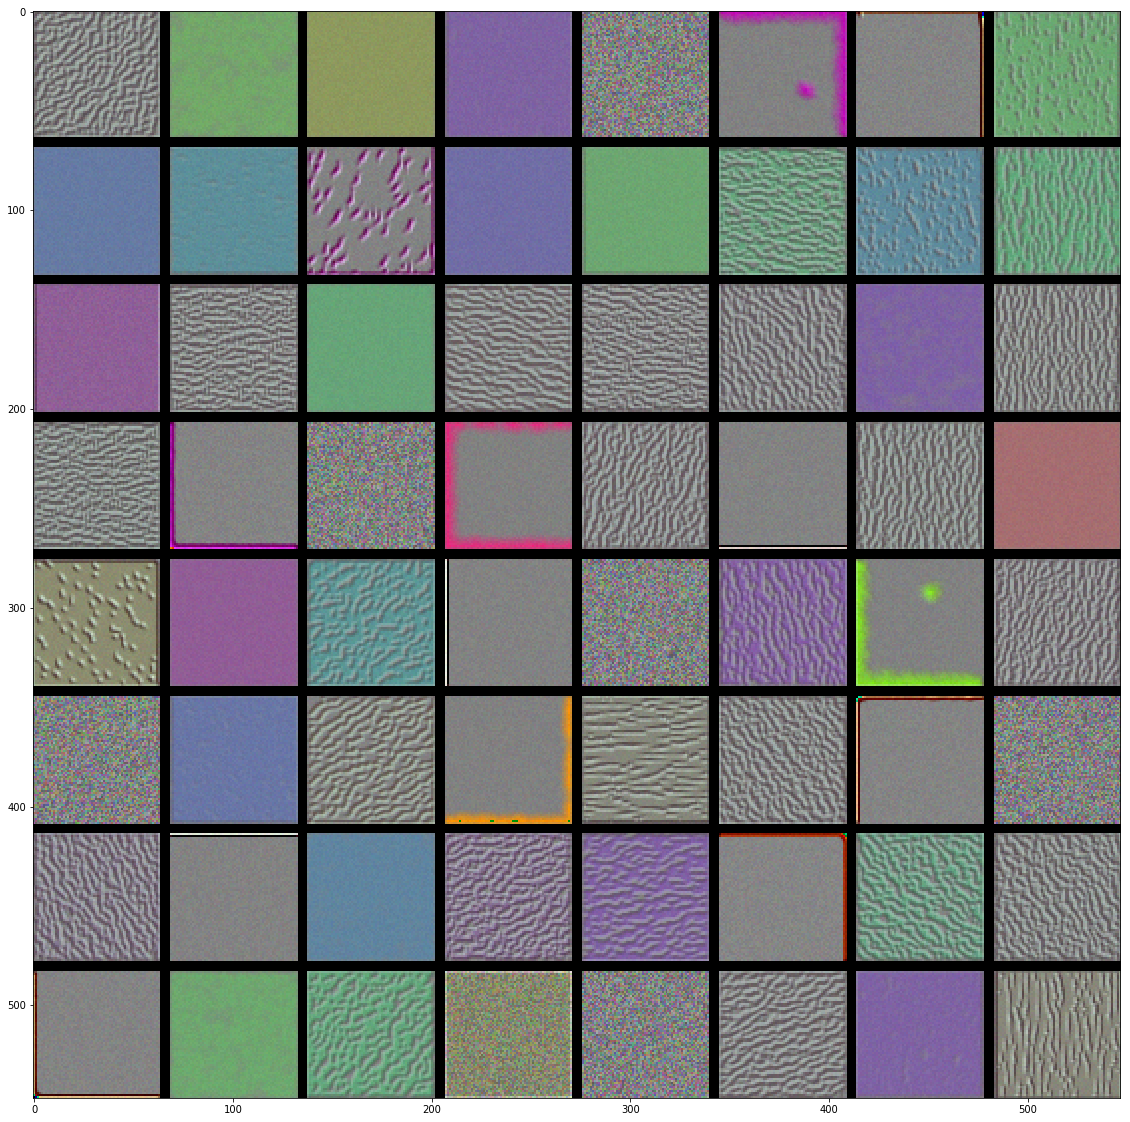

In [9]:
"""
Visualizing Convnet Filters (2)

These filter visualizations tell you a lot about how convnet layers see the world: each layer in a convnet learns a collection of filters
such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes signals
onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as you go higher
in the model:
-- The filters from the first layer in the model (block1_conv1) encode simple directional edges and colors (or colored edges, in some cases).
-- The filters from block2_conv1 encode simple textures made from combinations of edges and colors.
-- The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on. 
"""

layer_name = 'block1_conv1'
size = 64
margin = 5

# Empty (black) image to store results
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

# Iterates over the rows of the results grid
#     Iterates over the columns of the results grid
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
        vertical_start: vertical_end, :] = filter_img

# display
plt.figure(figsize=(20, 20))
plt.imshow(results)

In [17]:
"""
Visualizing Heatmaps of Class Activation (1)

1. This is one visualization technique that is useful for understanding which parts of a given image led a convnet to its final
   classification decision. This is helpful for debugging the decision process of a convnet, particularly in the case of a classification
   mistake. It also allows you to locate specific objects in an image.

2.  This general category of techniques is called class activation map (CAM) visualization, and it consists of producing heatmaps of class
    activation over input images. A class activation heatmap is a 2D grid of scores associated with a specific output class, computed
    for every location in any input image, indicating how important each location is with respect to the class under consideration. 

3. Grad-CAM: it consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that
   feature map by the gradient of the class with respect to the channel. Intuitively, one way to understand this trick is that you’re
   weighting a spatial map of “how intensely the input image activates different channels” by “how important each channel is with regard
   to the class,” resulting in a spatial map of “how intensely the input image activates the class.”
"""
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# include the densely connected classifier on top in this model
model = VGG16(weights='imagenet')

# load image to array
img_path = 'data/creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Preprocesses the batch (this does channel-wise color normalization)
x = preprocess_input(x)

# predicts
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(np.argmax(preds[0]))

Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]
386


(?, 14, 14, 512)
(512,)


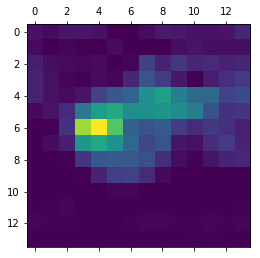

In [24]:
"""
Visualizing Heatmaps of Class Activation (2): Setting up the Grad-CAM algorithm
"""

# “African elephant” entry in the prediction vector
african_elephant_output = model.output[:, 386]

# output feature map of the block5_conv3 layer, the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# gradient of the “African elephant” class with regard to the output feature map of block5_conv3
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
print(grads.shape)

# vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature-map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)

# lets you access the values of the quantities defined: pooled_grads and the output feature map of block5_conv3, given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# values of these two quantities, as Numpy arrays, given the sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# multiplies each channel in the feature-map array by “how important this channel is” with regard to the “elephant” class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# the channel-wise mean of the resulting feature map is the heatmap of the class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

# heatmap postprocess
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [28]:
"""
Visualizing Heatmaps of Class Activation (3):  Superimposing the heatmap with the original picture
"""
import cv2

# use opencv load the orignial image
img = cv2.imread(img_path)

# resizes the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# converts to RGB
heatmap = np.uint8(255 * heatmap)

# applies the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# save on disk
cv2.imwrite('data/elephant_cam.jpg', superimposed_img)


True